In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, gamma, lognorm, weibull_min, gaussian_kde, skew, genpareto
from scipy.interpolate import make_interp_spline
import seaborn as sns
from copulas.multivariate import GaussianMultivariate
from sklearn.preprocessing import QuantileTransformer
import pymannkendall as mk
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import itertools
from itertools import combinations
from sklearn.model_selection import train_test_split

### 11b) 

#### Data Processing and Reading in / Cleaning Predictors

In [73]:
#Read in the initial data__________________________________________________________________________________________
lee_ferry = pd.read_csv('LeesFerry-monflows-1906-2016.txt', delimiter=' ', header=None)
lee_ferry.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
lee_ferry = lee_ferry.set_index('Year')
spring_flow = lee_ferry[['Apr', 'May', 'June', 'July']]
spring_flow.reset_index(inplace=True)
# spring_flow = spring_flow.drop('Year', axis = 1)
spring_flow_summed = pd.DataFrame(spring_flow.sum(axis=1)) / 10**6
# spring_flow = spring_flow.drop('Year')
spring_flow_summed.columns = ['Spring_Flow_Sums']






#Read in all predictor variables and combine_____________________________________________________________________________________
s_oscillation = pd.read_csv('NINO34-summer-1906-2016.txt', delimiter=' ', header=None)
s_oscillation.columns = ['Southern_Oscillation']
p_oscillation = pd.read_csv('PDO-winter-1906-2016.txt', delimiter=' ', header=None)
p_oscillation.fillna(0)
p_oscillation = pd.DataFrame(p_oscillation.stack())
p_oscillation.reset_index(inplace=True)
p_oscillation = p_oscillation.drop(['level_0', 'level_1'], axis = 1)
p_oscillation.columns = ['Pacific Oscillation']
a_oscillation = pd.read_csv('AMO-winter-1906-2016.txt', delimiter=' ', header=None)
a_oscillation.fillna(0)
a_oscillation = pd.DataFrame(a_oscillation.stack())
a_oscillation.reset_index(inplace=True)
a_oscillation = a_oscillation.drop(['level_0', 'level_1'], axis = 1)
a_oscillation.columns = ['Atlantic_Oscillation']
SWE = pd.read_csv('Mar1-and-Apr1-SWE-1906-2016.txt', delimiter=' ', header=None)
SWE.fillna(0)
SWE.columns = ['March SWE', 'April_SWE']

combined_all = pd.concat([SWE, a_oscillation, p_oscillation, s_oscillation,  spring_flow_summed], axis=1)
combined_all


,March SWE,April_SWE,Atlantic_Oscillation,Pacific Oscillation,Southern_Oscillation,Spring_Flow_Sums
0,120.11,210.08,-0.279944,0.708,0.110350,12.806274
1,180.01,217.26,-0.336088,0.068,0.529225,15.240647
2,114.74,141.56,-0.294875,0.886,-0.414587,7.485389
3,189.36,211.64,-0.116893,0.682,-0.254512,15.784871
4,160.19,175.98,-0.351587,-0.236,-0.872450,9.506008
...,...,...,...,...,...,...
106,104.09,117.54,0.337416,-1.480,0.626923,4.411456
107,104.75,125.99,0.327977,-0.452,-0.086700,5.352976
108,114.91,144.06,0.264938,0.226,0.446367,9.664630
109,117.21,140.35,0.260131,2.196,1.973837,8.886557


##### A note - I don't know what "previous years spring flow means", I looked at the example R code and sent an email but it stll is not obvious. If I were to use the previous year's spring flow, that is 4 data points and will break the function. Also, I am treating each SWE column as it's own predictor

In [78]:
Y = np.array(combined_all['Spring_Flow_Sums'])
X = combined_all[['March SWE', 'April_SWE', 'Atlantic_Oscillation', 'Pacific Oscillation', 'Southern_Oscillation']]

columns = X.columns
names_final = []
aic_final = []  # Storing AIC for each combination
models_final = []  # Store fitted models

for i in range(1, len(columns) + 1):
    combinations = itertools.combinations(columns, i)
    for combination in combinations:
        # Create a DataFrame with the selected columns from X
        subset_df = X[list(combination)]
        
        # Add a constant to the model (for the intercept)
        subset_df = sm.add_constant(subset_df)
        
        # Fit the OLS model
        model = sm.OLS(Y, subset_df).fit()
        
        # Store the AIC and model
        aic = model.aic
        names_final.append(combination)
        aic_final.append(aic)
        models_final.append(model)

results_df = pd.DataFrame({'Combination': names_final, 'AIC': aic_final})
# print(results_df)

sorted_results = results_df.sort_values(by='AIC').reset_index(drop=True)

best_model_idx = sorted_results.index[0]
best_combination = sorted_results.iloc[0]['Combination']
best_model = models_final[best_model_idx]

next_best_model_idx = sorted_results.index[1]
next_best_combination = sorted_results.iloc[1]['Combination']
next_best_model = models_final[next_best_model_idx]

print(f"Best Model (AIC: {sorted_results.iloc[0]['AIC']}): {best_combination}")

best_coefficients = best_model.params
next_best_coefficients = next_best_model.params

print("\nBest Model Coefficients:")
print(best_coefficients)

Best Model (AIC: 516.6210394071531): ('April_SWE', 'Atlantic_Oscillation')

Best Model Coefficients:
const        2.326430
March SWE    0.064133
dtype: float64


In [79]:
predictors = ['April_SWE', 'Atlantic_Oscillation']
response = 'Spring_Flow_Sums'



formula = f"{response} ~ {' + '.join(predictors)}"
model = smf.ols(formula=formula, data=combined_all).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(f"\nFormula: {formula}")
# residuals = model.resid
# combo_names.append(combo)
# residuals_final
print(anova_results)


Formula: Spring_Flow_Sums ~ April_SWE + Atlantic_Oscillation
                          sum_sq     df          F        PR(>F)
April_SWE             589.358666    1.0  98.427820  7.050430e-17
Atlantic_Oscillation   63.528192    1.0  10.609739  1.503748e-03
Residual              646.674243  108.0        NaN           NaN


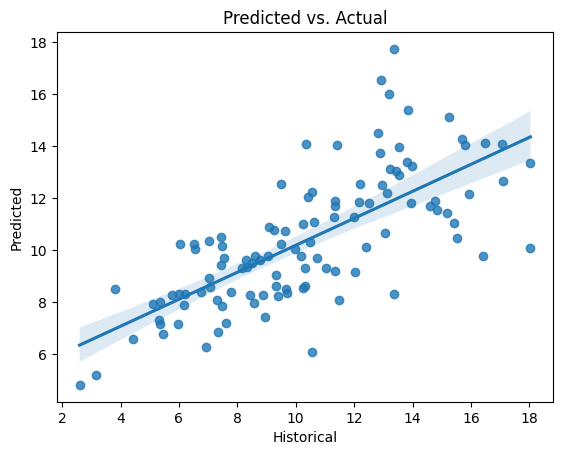

In [85]:
Y = np.array(combined_all['Spring_Flow_Sums'])
best_model_variables = combined_all[['April_SWE', 'Atlantic_Oscillation']]
best_constant = sm.add_constant(best_model_variables)
best_model_2 = sm.OLS(Y, best_constant).fit()
predictions = best_model_2.get_prediction(best_constant)
pred = predictions.predicted_mean
pred
sns.regplot(x = Y, y = pred)
plt.xlabel('Historical')
plt.ylabel('Predicted')
plt.title('Predicted vs. Actual')
plt.show()


#### April Snow Water Equivalent and Atlantic Oscillation are the most important variables for predicting spring flow. April SWE explains the majority of the variation and is a highly significant predictor, per the ANOVA results

#### Model Diagnostics


In [86]:
best_constant = sm.add_constant(best_model_variables)
best_mode_2 = sm.OLS(Y, best_constant).fit()

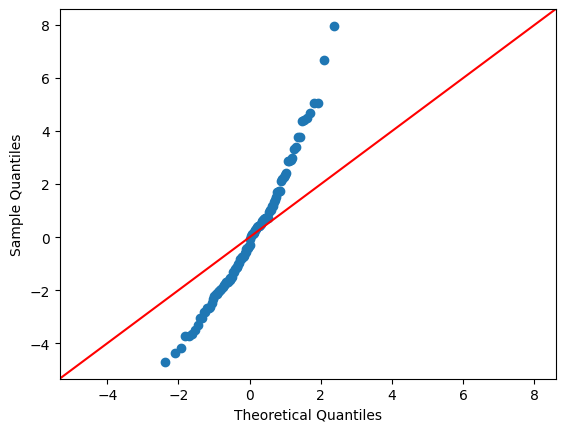

In [87]:
residuals = model.resid
sm.qqplot(residuals, line ='45')
plt.show()

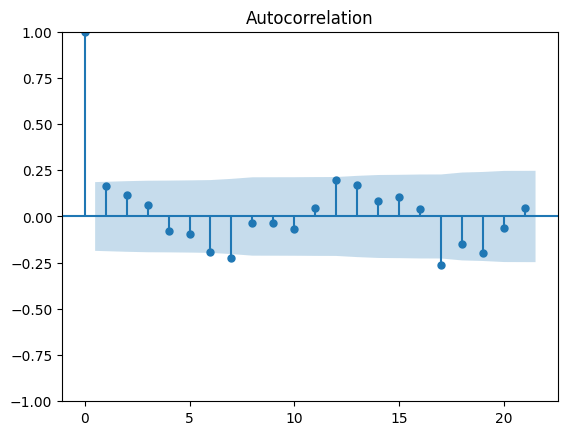

In [88]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals)
plt.show()

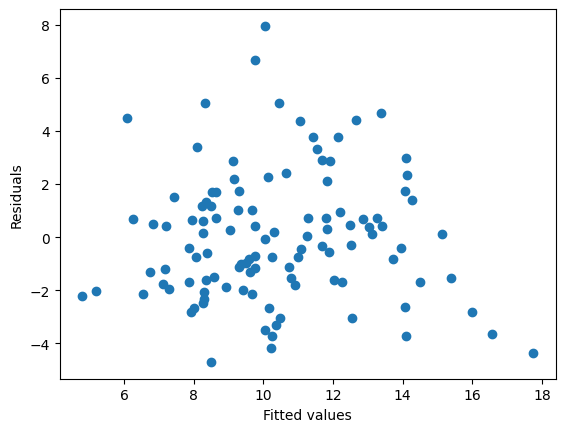

In [89]:
fitted_values = model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

#### All model diagnostics besides QQ look fine

### C)

In [91]:
def skill():
    rmse_final = []
    R = []
    for i in range(0,100):
        predictor = combined_all[['April_SWE', 'Atlantic_Oscillation']]
        y =  np.array(combined_all['Spring_Flow_Sums'])
        X_train, X_test, y_train, y_test = train_test_split(predictor,y, test_size=0.1, shuffle=True) 
        formula = "Spring_Flow_Sums ~ April_SWE + Atlantic_Oscillation"
        train_data = X_train.copy()
        train_data['Spring_Flow_Sums'] = y_train
        model = smf.ols(formula=formula, data=train_data).fit()
        test_data = X_test.copy()
        test_data['Spring_Flow_Sums'] = y_test  # Include target variable for comparison
        predictions = model.get_prediction(test_data)
        LOGTN_pred = predictions.predicted


        error = y_test - LOGTN_pred
        mse = np.mean(error ** 2)  # Mean Squared Error
        rmse = np.sqrt(mse)  # Root Mean Squared Error
        rmse_final.append(rmse)
        
        # Calculate R-squared
        y_mean = y.mean()
        SSt = np.sum((y_test - y_mean) ** 2)  # Total Sum of Squares (test data)
        se = np.sum(error ** 2)  # Residual Sum of Squares
        R2 = 1 - (se / SSt)  # R-squared
        R.append(R2)
    
    return rmse_final, R

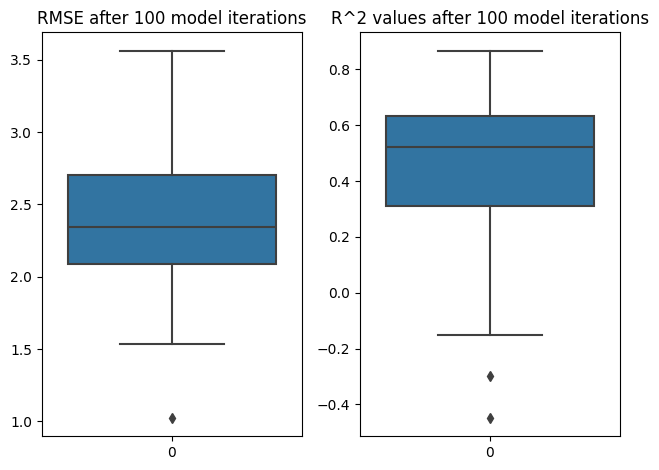

In [97]:
rmse_final, R = skill()
fig, axes = plt.subplots(1,2)
sns.boxplot(rmse_final, ax = axes[0])
axes[0].set_title('RMSE after 100 model iterations')
sns.boxplot(R, ax = axes[1])
axes[1].set_title('R^2 values after 100 model iterations')
plt.tight_layout()
plt.show()


### D) Bootstrap the data and obtain the estimates of the model parameters for each bootstrap sample. Repeat 500 times. Plot the parameter estimates as a histrogram along with the estimate from the original sample

In [ ]:
def bootstrap(data, num_samples):
    bootstraped_data = []
    for _ in range(num_samples): #does it num_samples amount of time 
        boot_sample = np.random.choice(data, replace=True) #resamples the data with replacement 
        bootstraped_data.append(boot_sample)
    return np.array(bootstraped_data)

data = may 
num_samples = 500
boot_data = bootstrap(may, num_samples)
boot_data